In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [4]:
class Encoder_conv(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=2, intermediate_dim=16, name="encoder", **kwargs):
        super(Encoder_conv, self).__init__(name=name, **kwargs)
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv2d_2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        self.concat = layers.Concatenate(axis=1)

    def call(self, inputs):
        img_dat, label = inputs
        x = self.conv2d_1(img_dat)
        x = self.conv2d_2(x)
        x = self.flatten(x)
        x = self.concat([x, label])  # MODIFICATION
        x = self.dense_proj(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [5]:
class Decoder_conv(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, intermediate_dim=16, name="decoder", **kwargs):
        super(Decoder_conv, self).__init__(name=name, **kwargs)
        self.dense_proj_1 = layers.Dense(intermediate_dim, activation="relu")
        self.dense_proj_2 = layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv2d_T_1 = layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv2d_T_2 = layers.Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv2d_T_3 = layers.Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')

    def call(self, inputs):
        x = self.dense_proj_1(inputs)
        x = self.dense_proj_2(x)
        x = self.reshape(x)
        x = self.conv2d_T_1(x)
        x = self.conv2d_T_2(x)
        return self.conv2d_T_3(x) 

In [6]:
class CVAE_conv(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=16,
        latent_dim=2,
        name="autoencoder",
        **kwargs
    ):
        super(CVAE_conv, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder_conv(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder_conv(intermediate_dim=intermediate_dim)
        self.concat = layers.Concatenate(axis=1)

    def call(self, inputs):
        img_dat, label = inputs
        z_mean, z_log_var, z = self.encoder(inputs)
        z_with_label = self.concat([z, label])  # MODIFICATION
        reconstructed = self.decoder(z_with_label)

        # Add KL divergence regularization loss.
        reconstruction_loss = keras.losses.binary_crossentropy(img_dat, reconstructed)
        reconstruction_loss = self.original_dim * K.mean(reconstruction_loss)
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss = -0.5 * K.mean(kl_loss)
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_loss(reconstruction_loss)
        self.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

        return reconstructed


In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255).reshape(60000, 28, 28, 1)
x_test = (x_test.astype("float32") / 255).reshape(10000, 28, 28, 1)

11493376/11490434 [==============================] - 1s 0us/step


In [8]:
# one-hot encoding response
enc = OneHotEncoder()
labels_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
labels_test = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

In [9]:

cvae_conv = CVAE_conv(28*28, 64, 2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

cvae_conv.compile(optimizer='adam')

epochs = 100

hist_conv = cvae_conv.fit(
    [x_train, labels_train], x_train,
    epochs=epochs, 
    batch_size=128, 
    validation_data=([x_test, labels_test], x_test)
)


Epoch 1/100
469/469 [==============================] - 40s 21ms/step - loss: 229.7412 - kl_loss: 1.5551 - mse_loss: 228.1861 - val_loss: 139.2035 - val_kl_loss: 4.3058 - val_mse_loss: 134.8978
Epoch 2/100
469/469 [==============================] - 9s 19ms/step - loss: 137.9944 - kl_loss: 4.4141 - mse_loss: 133.5803 - val_loss: 135.3909 - val_kl_loss: 4.4378 - val_mse_loss: 130.9531
Epoch 3/100
469/469 [==============================] - 9s 19ms/step - loss: 134.9503 - kl_loss: 4.5596 - mse_loss: 130.3907 - val_loss: 134.4921 - val_kl_loss: 4.4688 - val_mse_loss: 130.0233
Epoch 4/100
469/469 [==============================] - 9s 19ms/step - loss: 133.7366 - kl_loss: 4.6311 - mse_loss: 129.1055 - val_loss: 133.2751 - val_kl_loss: 4.6163 - val_mse_loss: 128.6589
Epoch 5/100
469/469 [==============================] - 9s 19ms/step - loss: 133.0332 - kl_loss: 4.6597 - mse_loss: 128.3735 - val_loss: 132.7323 - val_kl_loss: 4.5614 - val_mse_loss: 128.1708
Epoch 6/100
469/469 [==================

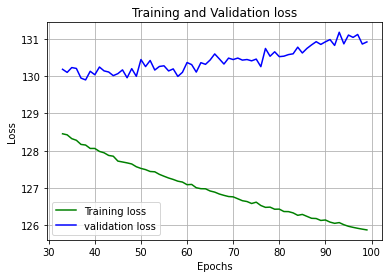

In [10]:
offset = epochs//3
loss_train = hist_conv.history['loss']
loss_val = hist_conv.history['val_loss']
epochs_x = range(offset, epochs)
plt.plot(epochs_x, loss_train[offset:], 'g', label='Training loss')
plt.plot(epochs_x, loss_val[offset:], 'b', label='validation loss')
plt.grid()
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

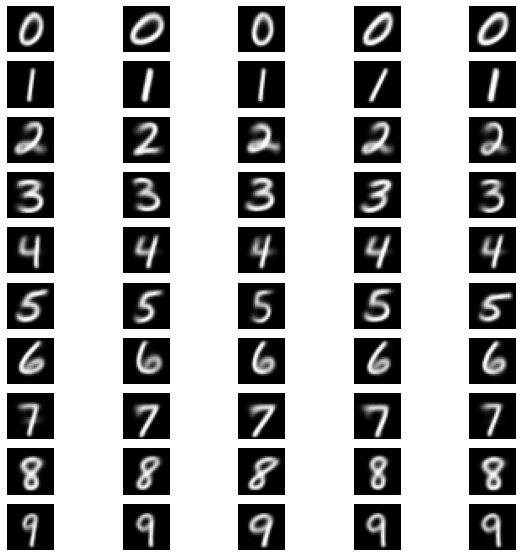

In [11]:

fig, axs = plt.subplots(10, 5, figsize=(10, 10))

for digit in range(10): # the digit you want to generate
  for i in range(5):
    digit_size = 28
    label = np.zeros(10)
    label[digit] = 1
    z_sample = np.random.uniform(-1, 1, 2).reshape(1, 2)
    x_decoded = cvae_conv.decoder(np.append(z_sample, label).reshape(1, 12))
    x_decoded = x_decoded.numpy()
    generated_digit = x_decoded[0].reshape(digit_size, digit_size)
    axs[digit, i].imshow(generated_digit, cmap='gray')
    axs[digit, i].axis('off')
